In [21]:
#pytorch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets

from torchvision.io import read_image

# plotting
from matplotlib import pyplot as plt

#arrays
import numpy as np # linear algebra


#pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
numepochs = 20
batch_size = 128
learning_rate = 0.01

In [24]:
#data loading
version = 'pristine'

In [25]:
%%time
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 3.28 ms, sys: 3.06 ms, total: 6.34 ms
Wall time: 5.07 ms


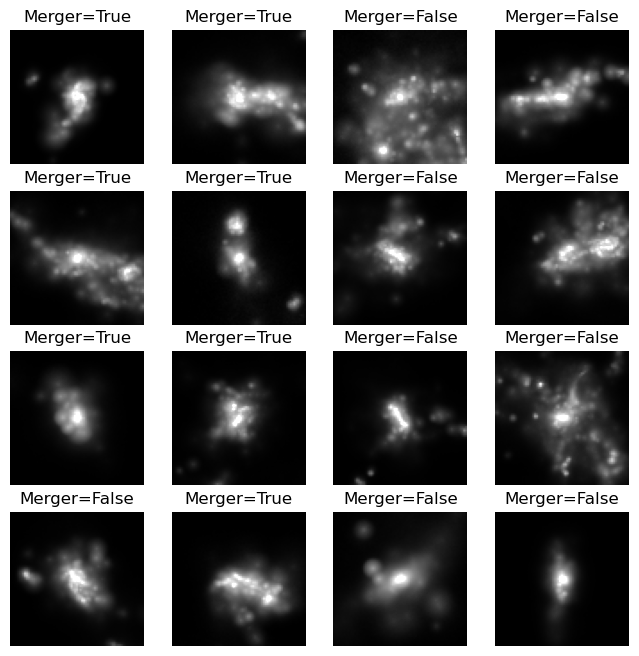

In [26]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
# np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(8, 8)) 

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))
    
    ax.axis('off')
    
plt.show()

In [27]:
X = hdu[0].data
y = hdu[1].data

In [28]:
# X = np.asarray(X).astype('float32')
# y = np.asarray(y).astype('float32')

In [29]:
imsize = np.shape(X)[2]
X = X.reshape(-1, imsize, imsize, 3)
X.shape

(15426, 75, 75, 3)

In [30]:
import pprint as pp

from sklearn import datasets

import numpy as np

import torch 
from torch.utils.data import Dataset 
from torch.utils.data import random_split

In [31]:
class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y

    def __getitem__(self, index):
        sample = {
            'feature': torch.tensor([self.x[index]], dtype=torch.float32), 
            'label': torch.tensor([self.y[index]], dtype=torch.long)}
        return sample

    def __len__(self):
        return len(self.x)

In [32]:
torch_dataset = CreateDataset(X,y)

In [33]:
d_train, d_test, d_valid = random_split(torch_dataset, [0.7, 0.2, 0.1])
#any way i can choose a random state?
#also do i really NEED to define a class?

In [34]:
#this is the structure of the model--->

class NNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8,16, 3)
        self.conv2 = nn.Conv2d(16,32, 3)
        # self.batchnorm = nn.BatchNorm2d()
        self.mpool = nn.MaxPool2d(kernel_size = 2, padding = 'valid')
        self.dropout = nn.Dropout2d(p = 0.5)
        # self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,1)
    def forward(self, x):
        x = self.dropout(self.mpool(F.batch_norm(F.relu(self.conv1(x)))))
        x = self.dropout(self.mpool(F.batch_norm(F.relu(self.conv2(x)))))
        x = self.dropout(self.mpool(F.batch_norm(F.relu(self.conv3(x)))))
        x = torch.flatten(x)
        x = F.Softmax(self.fc1(x))
        x = F.Softmax(self.fc2(x))
        x = F.Sigmoid(self.fc3(x))

In [35]:
# F.relu() (which is to say torch.nn.functional.relu()) is a
# function. nn.ReLU (torch.nn.ReLU) is a class that simply calls
# F.relu(). These two ways of packaging the function do the same
# thing, including when calling .backward().

In [36]:
model = NNet().to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [37]:
for epoch in range(numepochs): 
    for batch in d_train:
        optimizer.zero_grad()
        input, target = batch
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

TypeError: conv2d() received an invalid combination of arguments - got (str, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!str!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [ ]:
# def train_one_epoch(epoch_index, tb_writer):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(d_train):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels)
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         if i % 1000 == 999:
#             last_loss = running_loss / 1000 # loss per batch
#             print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(d_train) + i + 1
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0.

#     return last_loss

In [38]:
# # Initializing in a separate cell so we can easily add more epochs to the same run
# from datetime import datetime
# from torch.utils.tensorboard import SummaryWriter

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = numepochs

# best_vloss = 1_000_000.

# for epoch in range(EPOCHS):
#     print('EPOCH {}:'.format(epoch_number + 1))

#     # Make sure gradient tracking is on, and do a pass over the data
#     model.train(True)
#     avg_loss = train_one_epoch(epoch_number, writer)


#     running_vloss = 0.0
#     # Set the model to evaluation mode, disabling dropout and using population
#     # statistics for batch normalization.
#     model.eval()

#     # Disable gradient computation and reduce memory consumption.
#     with torch.no_grad():
#         for i, vdata in enumerate(d_valid):
#             vinputs, vlabels = vdata
#             voutputs = model(vinputs)
#             vloss = loss_fn(voutputs, vlabels)
#             running_vloss += vloss

#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     epoch_number += 1